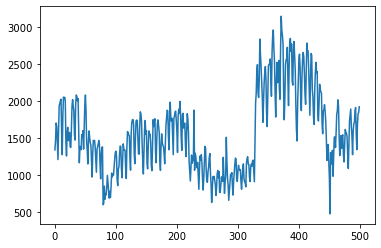

--------------------
Test statistics   -1.874616
p-value            0.344095
dtype: float64


In [346]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np

def stat_test(series_value):    
    #Let's check if the series is stationary:
    print("--------------------")
    stat_test = adfuller(series_value)
    test_result = pd.Series(stat_test[0:2], index = ['Test statistics', 'p-value'])

    print(test_result)

tr = {"Traffic": list(pd.read_csv("./traffic.txt", sep='\n', header=None)[0])}

n = 500 
days=1;

array_days = []

for idx,tr in enumerate(tr["Traffic"]):
    array_days.append(days)
    if days==6:
        days = 0
    else:
        days+=1

traffic["Days"] = array_days    
traffic = pd.DataFrame(traffic)

traffic["Traffic"].plot()
plt.show()
stat_test(traffic["Traffic"])

In [347]:
# Log function
# Log function
log_series = pd.Series(np.log(traffic["Traffic"].values), index = traffic["Days"])
stat_test(log_series.values)

--------------------
Test statistics   -2.172465
p-value            0.216390
dtype: float64


In [348]:
# Removing the rolling mean
moving_average = traffic["Traffic"].rolling(window = 30).mean()
df_no_average = traffic["Traffic"].shift(periods = 29) - moving_average
no_mean_series = pd.Series(df_no_average.values, index = traffic["Days"])
no_mean_series.dropna(inplace = True)
stat_test(no_mean_series)

--------------------
Test statistics   -3.516963
p-value            0.007562
dtype: float64


In [349]:
# Differentiating
diff_series = pd.Series(traffic["Traffic"].diff().values, index = traffic["Days"])
diff_series.dropna(inplace = True)
stat_test(diff_series)


--------------------
Test statistics   -6.771879e+00
p-value            2.629232e-09
dtype: float64


In [350]:
# Applying both options:
log_moving_average = log_series.rolling(window = 30).mean()
log_no_average = log_series.shift(periods = 29) - log_moving_average
log_no_mean_series = pd.Series(log_no_average.values, index = traffic["Days"])
log_no_mean_series.dropna(inplace = True)
stat_test(log_no_mean_series)

--------------------
Test statistics   -3.653763
p-value            0.004813
dtype: float64


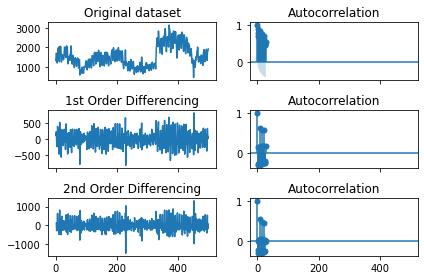

In [337]:
#ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Find d

# Original data set plot
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(traffic["Traffic"]); axes[0, 0].set_title('Original dataset')
plot_acf(traffic["Traffic"], ax=axes[0, 1])

# First order differencing
axes[1, 0].plot(traffic["Traffic"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(traffic["Traffic"].diff().dropna(), ax=axes[1, 1])

# Second order differencing
axes[2, 0].plot(traffic["Traffic"].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(traffic["Traffic"].diff().diff().dropna(), ax=axes[2, 1])

plt.savefig('ACF_differencing_plots')
plt.tight_layout()
plt.show()

In [351]:
first_diff = traffic["Traffic"].diff() # Differencing the first order
first_diff.dropna(inplace = True) # Removing problems
stat_test(first_diff)

--------------------
Test statistics   -6.771879e+00
p-value            2.629232e-09
dtype: float64


In [352]:
second_diff = first_diff.diff() # Differencing the second order
second_diff.dropna(inplace = True) # Removing problems
stat_test(second_diff)

--------------------
Test statistics   -1.296771e+01
p-value            3.128101e-24
dtype: float64


C:\Users\erycm\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


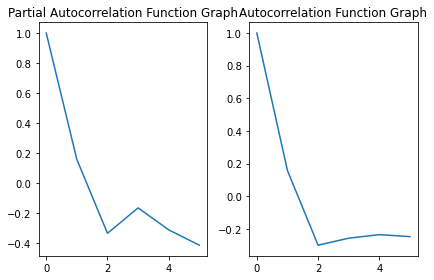

In [339]:
#find p and q


from statsmodels.graphics.tsaplots import acf, pacf

lets_find_p = pacf(first_diff, nlags=5) # Limited the lags for better visualization
lets_find_q = acf(first_diff, nlags=5) 

# Plotting
plt.subplot(121)
plt.plot(lets_find_p)
plt.title('Partial Autocorrelation Function Graph')

plt.subplot(122)
plt.plot(lets_find_q)
plt.title('Autocorrelation Function Graph')
plt.tight_layout()

C:\Users\erycm\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\erycm\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

201.4650281919086


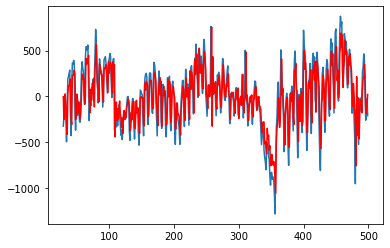

In [353]:
# (2,0,2)
from statsmodels.tsa.arima_model import ARIMA 
from math import sqrt
from sklearn.metrics import mean_squared_error

df_no_average.dropna(inplace=True) # Using the version without the rolling average

arima_model = ARIMA(df_no_average, order = (2,0,2))
arima_fit = arima_model.fit(disp = -1) # No convergence is outputted

shifted_df = df_no_average#.shift(periods=0) # The shifting concerns the differentiation order.
shifted_df.dropna(inplace = True)

rmse = sqrt(mean_squared_error(arima_fit.fittedvalues, shifted_df.values)) # error

plt.plot(df_no_average)
plt.plot(arima_fit.fittedvalues, color = 'red') # plotting the fit
print(rmse)

In [354]:
from scipy.optimize import curve_fit 

def linear_function(x, a, b): 
    return a + x*b 

moving_average.dropna(inplace = True)
moving_average.reset_index(drop = True, inplace = True)
param, param_cov = curve_fit(linear_function, moving_average.index, moving_average.values) 

def moving_average_function(x):
    return param[0] + param[1]*x


In [355]:
df_no_average_series = pd.Series(df_no_average.values)
concat_series = pd.concat([df_no_average_series, forecast_series])
index_ = np.linspace(0,len(concat_series)-1, len(concat_series))

moving_average_forecast = moving_average_function(index_) 
whole_series = pd.Series(concat_series.values+moving_average_forecast, index = concat_series.index)

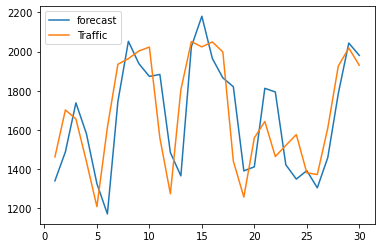

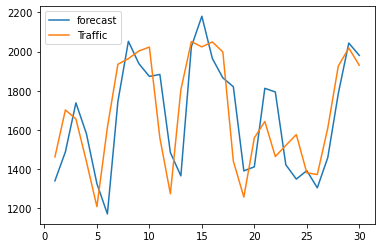

In [345]:
arima_fit.plot_predict(1,30) # 30 days ?? | confidence interval? 

C:\Users\erycm\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


187.9432642098257


C:\Users\erycm\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


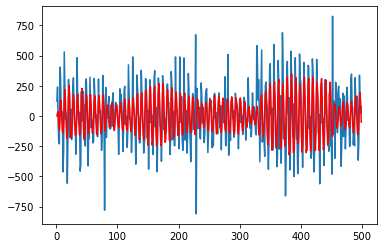

In [331]:
#2,1,2
# (2,1,2)
from statsmodels.tsa.arima_model import ARIMA 


arima_model = ARIMA(traffic["Traffic"], order = (2,1,2))
arima_fit = arima_model.fit(disp = -1) 

shifted_df = traffic["Traffic"].diff()
shifted_df.dropna(inplace = True)

rmse = sqrt(mean_squared_error(arima_fit.fittedvalues, shifted_df.values)) # error

plt.plot(traffic["Traffic"].diff())
plt.plot(arima_fit.fittedvalues, color = 'red') 
print(rmse)

In [344]:
fc, se, conf = arima_fit.forecast(29, alpha = 0.2) #forecasting 1 year, alpha is the confidence interval

last_date = pd.to_datetime(traffic["Days"].tail(1).values)
forecast_index = []
for i in range(len(fc)): # generating the forecast's index
    next_date = last_date + pd.DateOffset(days = 30)
    forecast_index.append(next_date[0])
    last_date = next_date

forecast_series = pd.Series(fc, index = forecast_index)
forecast_series

1970-01-31 00:00:00.000000003    1754.450010
1970-03-02 00:00:00.000000003    1589.979678
1970-04-01 00:00:00.000000003    1551.101476
1970-05-01 00:00:00.000000003    1666.085978
1970-05-31 00:00:00.000000003    1847.936003
1970-06-30 00:00:00.000000003    1960.701488
1970-07-30 00:00:00.000000003    1921.603099
1970-08-29 00:00:00.000000003    1762.261963
1970-09-28 00:00:00.000000003    1603.763430
1970-10-28 00:00:00.000000003    1565.172946
1970-11-27 00:00:00.000000003    1674.611416
1970-12-27 00:00:00.000000003    1849.291812
1971-01-26 00:00:00.000000003    1958.638784
1971-02-25 00:00:00.000000003    1922.383725
1971-03-27 00:00:00.000000003    1769.951746
1971-04-26 00:00:00.000000003    1617.220024
1971-05-26 00:00:00.000000003    1578.959027
1971-06-25 00:00:00.000000003    1683.105954
1971-07-25 00:00:00.000000003    1850.891371
1971-08-24 00:00:00.000000003    1956.909234
1971-09-23 00:00:00.000000003    1923.337000
1971-10-23 00:00:00.000000003    1777.526539
1971-11-22

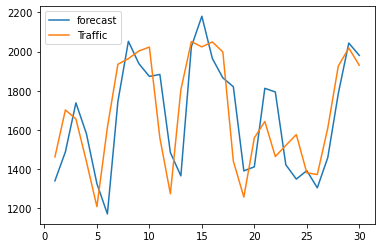

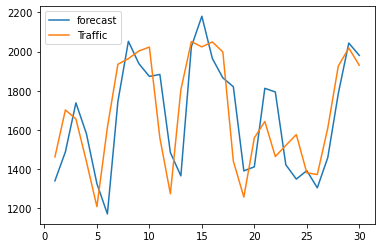

In [343]:
arima_fit.plot_predict(1,30) # predicting 30 days?? | confidence interval? 